In [1]:
import sys
sys.path.append('../')
from matplotlib import pyplot as plt

import pyreadr
import numpy as np
import pandas as pd
import copy
from scipy.optimize import fmin_slsqp
from sklearn.metrics import mean_squared_error

In [2]:
START_TIME = 1970
INTERVENTION_TIME = 1989
STOP_TIME = 2001

'smoking.rda' data taken from https://github.com/johnson-shuffle/mixtape/tree/master/data

'prop99.csv' taken from https://github.com/jehangiramjad/tslib/tree/master/tests/testdata

In [3]:
# df_outcome_raw = pd.read_csv('tobacco/prop99.csv')
# df_outcome_raw = df_outcome_raw[df_outcome_raw['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
# df_outcome = pd.DataFrame(df_outcome_raw.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year']).to_records())

# rda_predictors = pyreadr.read_r('tobacco/smoking.rda')
# df_predictors = pd.DataFrame(list(rda_predictors.values())[0])

In [4]:
# print(f'In the original dataset there are {df_outcome.LocationDesc.unique().shape[0]} states')
# # Section 3.2 in the paper
# bad_states = ['Massachusetts', 'Arizona', 'Oregon', 'Florida', 'Alaska', 'Hawaii', 'Maryland', 
#               'Michigan', 'New Jersey', 'New York', 'Washington', 'District of Columbia']

# df_outcome.drop(df_outcome[df_outcome['LocationDesc'].isin(bad_states)].index, inplace=True)
# ca_id = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item()
# df_outcome = df_outcome.reset_index()
# df_outcome = df_outcome.rename(columns={'index': 'org_index'})
# print(f'After filtering out some states, we are left with {df_outcome.LocationDesc.unique().shape[0]} states (including California):')
# df_outcome.head()

In [5]:
# df_outcome_ca = df_outcome.loc[df_outcome['LocationDesc'] == 'California', :]
# df_outcome_control = df_outcome.loc[df_outcome['LocationDesc'] != 'California', :]

# ca_outcomes_pre = df_outcome_ca.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.reshape(-1,1)
# control_outcomes_pre = df_outcome_control.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.transpose()

# ca_outcomes_post = df_outcome_ca.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.reshape(-1,1)
# control_outcomes_post = df_outcome_control.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.transpose()

# Z0 = control_outcomes_pre
# Z1 = ca_outcomes_pre
# Y0 = control_outcomes_post
# Y1 = ca_outcomes_post

In [6]:
df = pd.read_stata('synth_smoking.dta')

# deal with predictors
predictors_avg_df = df[(df['year'] >= 1980) & (df['year'] <= 1988)].groupby('state').mean()
predictors_avg_df.drop(columns='year', inplace=True)  # Drop the 'year' column after averaging
predictors_avg_df = predictors_avg_df.drop(columns='cigsale')
beer_avg = df[(df['year'] >= 1984) & (df['year'] <= 1988)].groupby('state')['beer'].mean()
predictors_avg_df['beer'] = beer_avg
cigsale1975 = df[df['year'] == 1975].set_index('state')['cigsale']
cigsale1980 = df[df['year'] == 1980].set_index('state')['cigsale']
cigsale1985 = df[df['year'] == 1985].set_index('state')['cigsale']
# Rename the series for clarity when adding them to the DataFrame
cigsale1975.name = 'cigsale1975'
cigsale1980.name = 'cigsale1980'
cigsale1985.name = 'cigsale1985'
# Add these series to the predictors DataFrame
predictors_avg_df = predictors_avg_df.join(cigsale1975)
predictors_avg_df = predictors_avg_df.join(cigsale1980)
predictors_avg_df = predictors_avg_df.join(cigsale1985)
predictors_avg_df = predictors_avg_df.T  # Transpose if your predictors are currently in rows
california_predictors_df = predictors_avg_df[['California']]
non_california_predictors_df = predictors_avg_df.drop(columns='California')

# deal with responses
response_df = df.pivot(index='year', columns='state', values='cigsale')
california_response_df = response_df[['California']]
non_california_response_df = response_df.drop(columns='California')
california_pre_1988_df = california_response_df[california_response_df.index <= 1988]
california_post_1988_df = california_response_df[california_response_df.index > 1988]
non_california_pre_1988_df = non_california_response_df[non_california_response_df.index <= 1988]
non_california_post_1988_df = non_california_response_df[non_california_response_df.index > 1988]


In [7]:
X0 = non_california_predictors_df
X1 = california_predictors_df
Z0 = non_california_pre_1988_df
Z1 = california_pre_1988_df
Y0 = non_california_post_1988_df
Y1 = california_post_1988_df

In [21]:
X0.to_csv('X0.csv', index=False)
X1.to_csv('X1.csv', index=False)
Z0.to_csv('Z0.csv', index=False)
Z1.to_csv('Z1.csv', index=False)
Y0.to_csv('Y0.csv', index=False)
Y1.to_csv('Y1.csv', index=False)

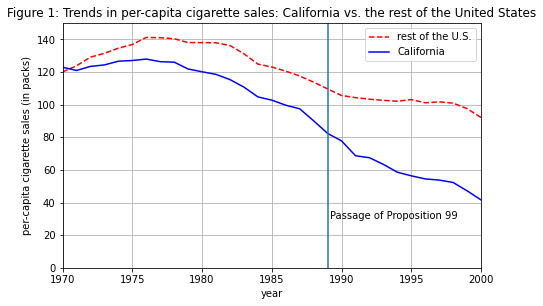

In [8]:
mean_outcomes = np.vstack([Z0, Y0]).mean(axis=1)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5))
plt.plot(range(START_TIME,STOP_TIME),mean_outcomes, 'r--', label="rest of the U.S.");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 1: Trends in per-capita cigarette sales: California vs. the rest of the United States")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 150])
plt.grid()
plt.show()
fig.savefig("name", dpi=300)

In [9]:
# def extract_predictor_vec(state):
#     df_outcome_state = df_outcome[df_outcome['LocationDesc'] == state]
#     cigsale88_predictor = df_outcome_state['1988'].item()
#     cigsale80_predictor = df_outcome_state['1980'].item()
#     cigsale75_predictor = df_outcome_state['1975'].item()
    
#     state_id_predictors_df = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item() + 1
#     df_predictors_state = df_predictors[df_predictors['state'] == state_id_predictors_df]
#     beer_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1984) & (df_predictors_state['year'] < INTERVENTION_TIME), 'beer'].mean()
#     age15to24_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'age15to24'].mean()*100  # Should I turn multiply by 100? In table 1 it looks like it
#     retprice_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'retprice'].mean()
#     lnincome_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'lnincome'].mean()
    
#     return np.array([lnincome_predictor, age15to24_predictor, retprice_predictor, beer_predictor,  
#                      cigsale88_predictor, cigsale80_predictor, cigsale75_predictor]).reshape(-1,1)

In [10]:
# control_predictors = []
# for state in df_outcome['LocationDesc'].unique():
#     state_predictor_vec = extract_predictor_vec(state)
#     if state == 'California':
#         ca_predictors = state_predictor_vec
#     else:
#         control_predictors += [state_predictor_vec]

# control_predictors = np.hstack(control_predictors)

# X0 = control_predictors
# X1 = ca_predictors

In [11]:
# extract_predictor_vec('California')

In [12]:
def w_mse(w, v, x0, x1): return mean_squared_error(x1, x0.dot(w), sample_weight=v)

def w_constraint(w, v, x0, x1): return np.sum(w) - 1

def v_constraint(V, W, X0, X1, Z0, Z1): return np.sum(V) - 1

def fun_w(w, v, x0, x1): return fmin_slsqp(w_mse, w, bounds=[(0.0, 1.0)]*len(w), f_eqcons=w_constraint, 
                                           args=(v, x0, x1), disp=False, full_output=True)[0]

def fun_v(v, w, x0, x1, z0, z1): return mean_squared_error(z1, z0.dot(fun_w(w, v, x0, x1)))

def solve_synthetic_control(X0, X1, Z0, Z1, Y0):
    k,j = X0.shape
    V0 = 1/k*np.ones(k)
    W0 = 1/j*np.zeros(j).transpose()
    V = fmin_slsqp(fun_v, V0, args=(W0, X0, X1, Z0, Z1), bounds=[(0.0, 1.0)]*len(V0), disp=True, f_eqcons=v_constraint, acc=1e-6)
    W = fun_w(W0, V, X0, X1)
    # V = np.ones(26) / 26
    # W = fun_w(W0, V, np.vstack((Z0, X0)), np.vstack((Z1, X1)))
    return V, W

V, W = solve_synthetic_control(X0, X1, Z0, Z1, Y0)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 4.338064150797884
            Iterations: 14
            Function evaluations: 170
            Gradient evaluations: 10


In [13]:
print(w_mse(W, V, X0, X1) * 38)

0.23567624540514878


In [14]:
print(V)

[0.14206264 0.14507941 0.14223481 0.14429097 0.14234733 0.14206349
 0.14244605]


In [15]:
a = pd.DataFrame({"State": non_california_response_df.columns.values, "Weight": W})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
a

,State,Weight
0,Alabama,0.00000
1,Arkansas,0.00000
2,Colorado,0.20303
3,Connecticut,0.06037
4,Delaware,0.00000
5,Georgia,0.00000
6,Idaho,0.00000
7,Illinois,0.00000
8,Indiana,0.00000
9,Iowa,0.00000


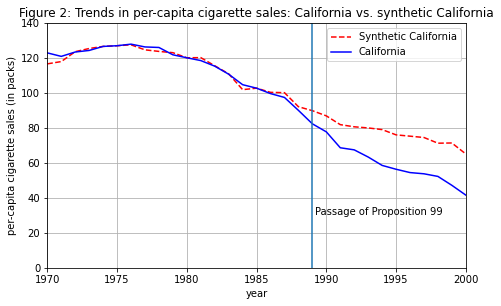

In [16]:
SC_outcomes = np.vstack([Z0, Y0]).dot(W)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5)) 

plt.plot(range(START_TIME,STOP_TIME),SC_outcomes, 'r--', label="Synthetic California");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 2: Trends in per-capita cigarette sales: California vs. synthetic California")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 140])
plt.grid()
plt.show()
fig.savefig("prop99_figure2", dpi=300)

#### Table 1

In [17]:
mean_predictors = X0.mean(axis=1).to_frame()
print("Table 1: Cigarette sales predictor means \n")
display(pd.DataFrame(np.hstack([X1, X0.dot(W).to_frame(), mean_predictors]), 
             columns=['Real California', 'Synthetic California', 'Average of 38 Controls']))

Table 1: Cigarette sales predictor means 



,Real California,Synthetic California,Average of 38 Controls
0,10.07656,9.86763,9.82920
1,24.28000,24.27905,23.65526
2,0.17353,0.17518,0.17251
3,89.42223,89.42148,87.26608
4,127.10000,127.09955,136.93159
5,120.20000,120.19666,138.08948
6,102.80000,102.80362,123.11580


#### Table 2: Top 5 donors

In [18]:
list( non_california_response_df.columns.values[np.flip(W.argsort())][:5])
# In the paper: Colorado, Connecticut, Montana, Nevada, Utah

['Utah', 'Nevada', 'Colorado', 'New Mexico', 'Connecticut']

#### Figure 3

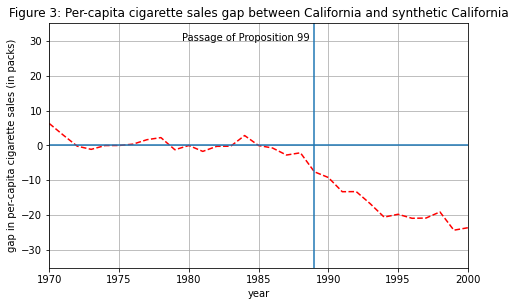

In [19]:
Gap_outcome = np.vstack([Z1, Y1]).flatten() - np.vstack([Z0, Y0]).dot(W)
fig = plt.figure(figsize=(7.5,4.5)) 

plt.plot(range(START_TIME,STOP_TIME),Gap_outcome, 'r--');
plt.ylabel('gap in per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.title("Figure 3: Per-capita cigarette sales gap between California and synthetic California")
plt.axhline(0)
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME-9.5, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([-35, 35])
plt.grid()
plt.show()
fig.savefig("prop99_figure3", dpi=300)